In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# ### Analysis Project 
# 
# ### 2022-11-2

# ### Statistical significance tests on movie ratings data
                    
# We acknowledge any outcome could be due to
# chance. Our only question is how likely that is by chance. If it is
# implausibly unlikely, we reject the assumption that it was just due to
# chance. And either the null hypothesis is true or not, so if we reject it
# is plausible, it probably means that our treatment did have an effect.                  
                    
#%% Before we do the stats, let's talk about the psychology of movie ratings:
    
# Hypothesis 1: There is no difference in the distribution of ratings between the two movies.

# Hypothesis 2: Distribution of ratings for one of the movies will be different from the other.

# Make sure that you actually have 2 plausible outcomes before doing the
# study. If the outcome is a foregone conclusion, it's not science. Science
# is about being open to any possible outcome.

# Null hypothesis: There is no difference. 

# Let's implement the canonical data analysis cascade



# b. Load/import - libraries/packages:

import pandas as pd
import numpy as np
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns


# Let me walk you through the null hypothesistesting framework at least once (just once). It is a bit arcane. It madesense to Fisher.         

### 1) Start with a hypothesis (something about the world you would wish toknow, whether it is true or not). 

### 2) State a null hypothesis and assume that it is 100% true (that there is no difference in the conditions of 1), e.g. here Matrix I rated the sameas Matrix II and III). This is essential to NHST. 

### 3) This is - at the face of it - an odd thing to do, because naively you would think that scientists look for probability (Hypothesis | Data) But that is unknowable. Which is why we do the study in the first place. What is calculable: Probability (Data | NULL hypothesis)You can assess the probability of the data given the null hypothesis

### 4) To get this probability, we represent the sample by a parameter like a sample mean, then transform the sample mean into a test statistic with a known distribution.

### 5) The area under the curve of the distribution of the test statistic in the tail (or tails, if it is a 2-tailed test) is the p value, in otherwords the probability of this result (or a more extreme one) given chancealone.

### 6) We compare the p value to a significance level alpha (typically 5% or 1%)

### 7) Decision point (Choice)
### a) If it is smaller than that, we decide to reject our assumption that the null hypothesis is true.
### b) If it is not smaller than that, we don't do anything because we alreadyassumed that the null hypothesis is true.                    

## 1. Loader / Transducer: Taking the inputs from their native form and putting it into something Python can use: a matrix

In [2]:
M = pd.read_csv('movieReplicationSet.csv')


OnlyChild = M.loc[M['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 1, 'The Lion King (1994)']
HasSibling = M.loc[M['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 0, 'The Lion King (1994)']
NoResponse = M.loc[M['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == -1, 'The Lion King (1994)']

OnlyChild = pd.to_numeric(OnlyChild,errors='coerce').values
HasSibling = pd.to_numeric(HasSibling,errors='coerce').values
NoResponse = pd.to_numeric(NoResponse,errors='coerce').values


In [3]:
OnlyChild

array([4. , 4. , 4. , 3.5, 3.5, 4. , nan, 4. , nan, 4. , 3.5, 4. , 2. ,
       4. , 4. , nan, nan, 4. , 4. , nan, 4. , 3.5, nan, 3. , 2.5, 3. ,
       4. , 3. , 4. , nan, 4. , 1. , 2. , 4. , nan, 3. , 3.5, 1.5, nan,
       nan, 3.5, 3.5, 4. , nan, 3. , 3. , nan, 3. , 0.5, 4. , 4. , 4. ,
       nan, 3.5, 4. , 4. , 3. , 3. , 3. , 3. , 4. , 3.5, 3.5, nan, 4. ,
       2.5, 4. , 3. , nan, 4. , 4. , 4. , 3. , 3.5, 3. , nan, 1.5, 3. ,
       2.5, 2.5, 4. , nan, 4. , 4. , 3.5, 2.5, nan, 4. , 4. , 3.5, 2. ,
       0.5, 3.5, 3. , 4. , 4. , 3.5, 4. , 4. , nan, 2.5, 2. , 3.5, nan,
       4. , 2.5, 4. , 4. , 4. , 3. , 4. , 0. , 2.5, 3. , 4. , 3.5, 4. ,
       4. , 3.5, 4. , 3. , 4. , 3. , nan, 2. , 4. , 3. , 3. , nan, nan,
       4. , 3.5, 4. , 3.5, 3. , nan, 3. , 3.5, 3. , 0.5, 4. , nan, 4. ,
       4. , 2.5, 4. , 3. , 4. , 3.5, 3.5, 3.5, 4. , 2. , 4. , 3.5, 4. ,
       nan, 3. , 3. , 3. , 4. , 2.5, 4. , 4. , 4. , 4. , 2.5, 3.5, 4. ,
       4. , 3. , 2.5, 3. , 3.5, 4. , 3.5, 3. ])

In [4]:
len(OnlyChild)

177

In [5]:
len(HasSibling)

894

In [6]:
len(NoResponse)

26

## 2. "Thalamus" stage: We need to get rid of "bad" data. 

### This is not data we don't like the results of.  It's data that if it entered the analysis stream would ruin our analysis. By visual inspection, the matrix of movie ratings contains numbers from 1 to 4, representing "star ratings", and "nans".  What could the nans be? What do they mean? It could be people not doing the task. There are many ways to detect this. People who press buttons not in the instructions, people responding too fast, people responding too slow. 

### Why might "too slow" be a problem? In one study, we were interested in reaction time as a dependent variable. But once, a participant went to the restroom in the middle of the experiment and didn't come back for 30 minutes. What would happen to the mean reaction time for the condition that the trial was in, in which this participant used the restroom. If we included this, it would be meaningless. The mean is sensitive to outliers. The rest of the reactions are in milli-seconds. This is 4 orders of magnitude higher. Another example from neuroscience: Voltages of electrodes are usually in mV or microV (depending on eeg vs. microelectrode). What if for one trial there was voltage surge that hit the building - all measurements from that trial are invalid. You need to exclude that BEFORE looking at the results. All results will be thrown off by that.

### Given that these are movie ratings, it is not implausible that most of these nans represent missing data due to the participant did not watch the movie in question. The reason we have to deal with this is that once this data is in the analysis stream, it will make the rest of the interpretation hard. If there is a single nan in the data, we can't take the mean.  So "filtering" or removing of ill-formed data will mean "removal of missing data" in this case.

## But here is the catch: Remove them how?

### There are at least 3 ways to handle this, and depending on how we do this, it will set up the entire rest of the analysis (and what it means). 

## 1. Element-wise removal of nans
### We remove nans from each data matrix where we find it. But we are starting with an equal n for each movie. 3204 rows in all 3 matrices. Once we start removing stuff element-wise, due to the fact that there are an unequal number of nans for each movie, this will result in unequal n, which will make some analyses impossible. Some analyses presume equal n. It could also introduce bias. If we remove people who have not seen the latter ones, but that was a choice (their choice), we would inflate the ratings artificially. 

## 2. Row-wise (participant-wise) removal of nans
### If a participant has not seen even one of the movies, we remove all of the data from this participant. Good: We keep n the same. Bad: We will lose a lot of data. Probably most of the data. This usually looks suspicious, also: Loss of statistical power. 

## 3. Imputation 
### We replace the missing data with our guess of what the rating would have been, if there had been a rating. This is more commonly done in engineering than in science.  Sometimes, people replace the missing value with the mean. But which mean? The participant-wise mean or the movie-wise mean - or a blend of the two? We could do the average of the movie, but is that fair? Those people chose not to watch it - they were not randomly assigned to watch the movies. This suggests that their rating would have been lower than that average. But how much lower? 0? Probably too extreme. In science, data only comes from measurement

### In real life, pick the option that makes the most sense for your theoretical approach, and just do that. For teaching purposes, we'll do all of them, just so you see how that plays out in real life.

In [7]:
# 1) Element-wise:

OnlyChild = OnlyChild[np.isfinite(OnlyChild)]
HasSibling = HasSibling[np.isfinite(HasSibling)]
# NoResponse = Self[np.isfinite(Self)]

print("elementwise removal:")
print("len M1 after removal: %s" % len(OnlyChild)) # 177 > 151
print("len M2 after removal: %s" % len(HasSibling)) # 894 > 776
# print("len M3 after removal: %s" % len(Self)) # 6 > 6

elementwise removal:
len M1 after removal: 151
len M2 after removal: 776


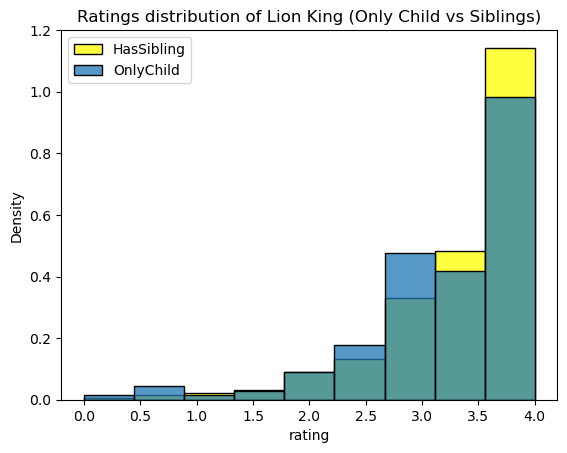

In [28]:
# ELEMENTWISE MOVIE 1 VS MOVIE 2


combinedData = np.transpose(np.array([OnlyChild,HasSibling], dtype=object)) # array of arrays


bins = 9

sns.histplot(combinedData[1], bins=bins, color="yellow", label="HasSibling", stat="density")
sns.histplot(combinedData[0], bins=bins, label="OnlyChild", stat="density")



plt.title('Ratings distribution of Lion King (Only Child vs Siblings)')
plt.xlabel('rating')
plt.ylabel('Density')
plt.legend()
plt.ylim([0, 1.2])
plt.show()

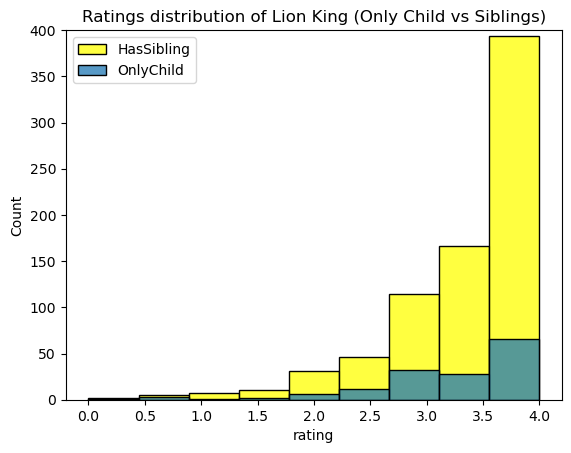

In [29]:
# ELEMENTWISE MOVIE 1 VS MOVIE 2


combinedData = np.transpose(np.array([OnlyChild,HasSibling], dtype=object)) # array of arrays


bins = 9

sns.histplot(combinedData[1], bins=bins, color="yellow", label="HasSibling")
sns.histplot(combinedData[0], bins=bins, label="OnlyChild")



plt.title('Ratings distribution of Lion King (Only Child vs Siblings)')
plt.xlabel('rating')
plt.ylabel('Count')
plt.legend()
plt.ylim([0, 400])
plt.show()

### I took the records that came in over time by participant and broke them up, so they are now ordered by movie. I already abstracted over time. There is still something we can do that will make our life easier, which is to put this into a format we can loop over (to do all these tests). Why is the current format not great? M1 vs. M3, etc. is not great for that? Wouldn't it be better to have a matrix "DATA" that contains all 3 movies? It would be. Why can't it be a matrix now, given we removed missing data element-wise? Because n is unequal. So let's make it an array of arrays

In [9]:
#%% 4a) Extrastriate cortex: Doing the actual specialized analyses
# Descriptive statistics - we are looking for very special numbers that
# capture the essence of the entire dataset - the typical number (central
# tendency) and the dispersion. Typically mean and SD. 

numGroups = 2

# Initialize container to store descriptives:
descriptivesContainer = np.empty([numGroups,5])
descriptivesContainer[:] = np.NaN 

# 1. Element-wise:
for ii in range(numGroups):
    descriptivesContainer[ii,0] = np.mean(combinedData[ii]) # mu
    descriptivesContainer[ii,1] = np.std(combinedData[ii]) # sigma
    descriptivesContainer[ii,2] = len(combinedData[ii]) # n
    descriptivesContainer[ii,3] = descriptivesContainer[ii,1]/np.sqrt(descriptivesContainer[ii,2]) # sem
    
    #median
    descriptivesContainer[ii,4] = np.median(combinedData[ii])

In [10]:
#%% 4b) Extrastriate cortex part II: Inferential statistics

# MOVIE 1: check mean, std-dev, n?, SEM -> FEMALE
descriptivesContainer[0]


array([3.34768212e+00, 8.13774985e-01, 1.51000000e+02, 6.62240691e-02,
       3.50000000e+00])

In [11]:
# MOVIE 2: check mean, std-dev, n?, SEM  -> MALE
descriptivesContainer[1]

array([3.48195876e+00, 7.17731448e-01, 7.76000000e+02, 2.57650574e-02,
       4.00000000e+00])

(0.0, 4.0)

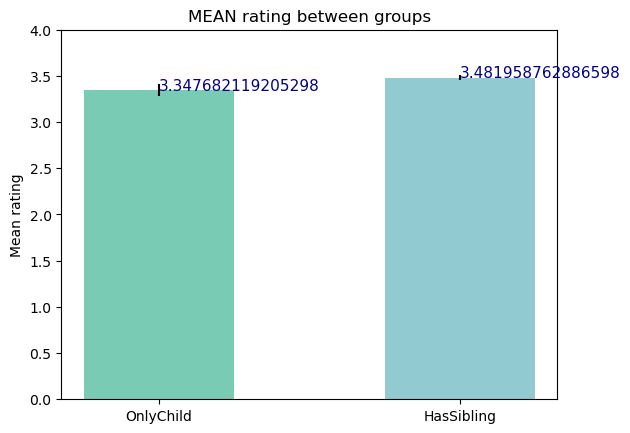

In [12]:
# First, lets plot our data 
# MEAN

font = {'family': 'sans-serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 11,
        }

c = ['#79ccb3', '#92cad1']


x = ['OnlyChild', 'HasSibling'] # labels for the bars
plt.text(1,descriptivesContainer[0][0],descriptivesContainer[0][0], fontdict=font)
plt.text(2,descriptivesContainer[1][0],descriptivesContainer[1][0], fontdict=font)
xPos = np.array([1,2]) # x-values for the bars


plt.bar(xPos,descriptivesContainer[:,0],width=0.5,yerr=descriptivesContainer[:,3], color=c) # bars + error  
plt.xticks(xPos, x) # label the x_pos with the labels

plt.title('MEAN rating between groups')
plt.ylabel('Mean rating') # add y-label
plt.ylim([0, 4])


(0.0, 4.5)

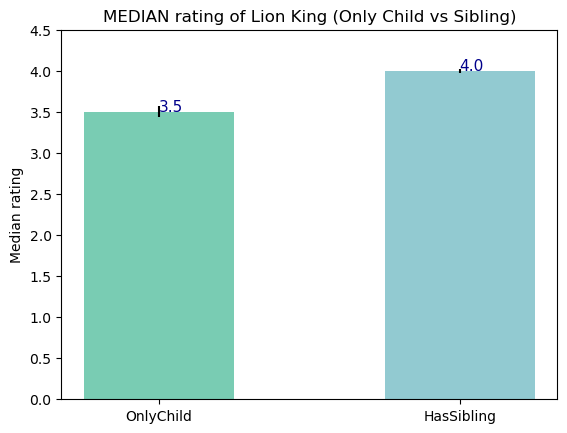

In [13]:
# First, lets plot our data 
# MEDIANS

font = {'family': 'sans-serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 11,
        }

c = ['#79ccb3', '#92cad1']


x = ['OnlyChild', 'HasSibling'] # labels for the bars


xPos = np.array([1,2]) # x-values for the bars

# q = plt.bar(xPos,descriptivesContainer[:,0])
# q.xticks(xPos, x) # label the x_pos with the labels
# q.yticks(fontsize=22)
# q.show()

plt.text(1,descriptivesContainer[0][4],descriptivesContainer[0][4], fontdict=font)
plt.text(2,descriptivesContainer[1][4],descriptivesContainer[1][4], fontdict=font)



plt.bar(xPos,descriptivesContainer[:,4],width=0.5,yerr=descriptivesContainer[:,3], color=c) # bars + error  

# plt.bar(xPos,descriptivesContainer[:,0])
plt.xticks(xPos, x) # label the x_pos with the labels
plt.yticks(fontsize=10)

plt.title('MEDIAN rating of Lion King (Only Child vs Sibling)')
plt.ylabel('Median rating') # add y-label
plt.ylim([0, 4.5])





In [14]:
# medians i did manually:

median_onlychild = np.median(combinedData[0])

median_onlychild

3.5

In [15]:
# medians i did manually:

median_sibs = np.median(combinedData[1])

median_sibs

4.0

In [16]:
# lets try mannwhitney u between each group
# Nonparametric tests equivalent to t-tests - Mann-Whitney U test:
# Test for comparing medians of ordinal data (such as movie ratings)
# from 2 groups
u1,p1 = stats.mannwhitneyu(combinedData[0],combinedData[1])
# u2,p2 = stats.mannwhitneyu(combinedData[0],combinedData[2])
# u3,p3 = stats.mannwhitneyu(combinedData[1],combinedData[2])

print("u1:%s p1:%s" % (u1,p1))
# print("u2:%s p2:%s" % (u2,p2))
# print("u3:%s p3:%s" % (u3,p3))

u1:52929.0 p1:0.04319872995682849


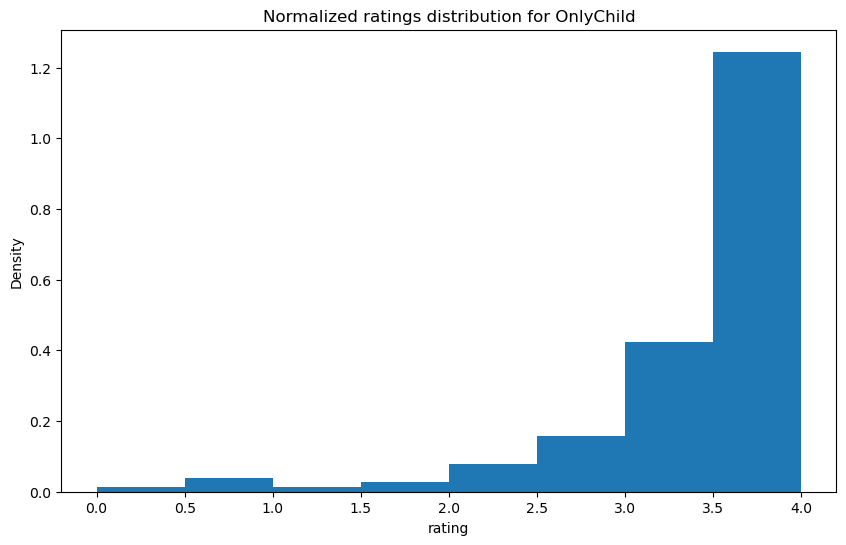

In [17]:
# lets also plot the density distribution of the two:

# plot the ratings distribution of all ratings for matrix_1 
bins=8
plt.figure(figsize=(10,6))
plt.hist(OnlyChild, bins=bins, density=True)
plt.title('Normalized ratings distribution for OnlyChild')
plt.xlabel('rating')
plt.ylabel('Density')
plt.show()

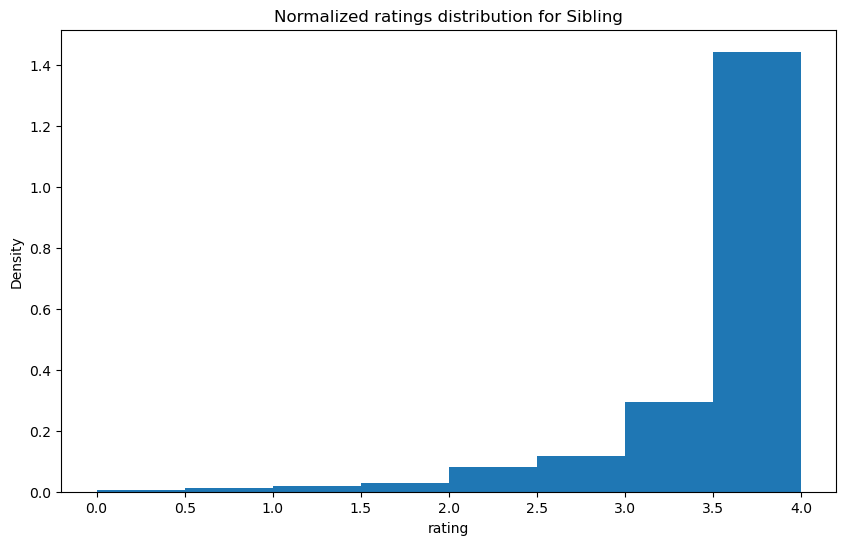

In [18]:

# plot the ratings distribution of all ratings for matrix_1 
bins=8
plt.figure(figsize=(10,6))
plt.hist(HasSibling, bins=bins, density=True)
plt.title('Normalized ratings distribution for Sibling')
plt.xlabel('rating')
plt.ylabel('Density')
plt.show()

### So far, they look they will be different. The mean rating of movie 1 (Home Alone) is lower than that of Finding Nemo.  The question here is whether the differences we saw in the descriptives - usually the means - are "statistically significant".  Whether it is plausibly consistent with chance (that the numbers came out of a RGN)

### 1) Assert a null hypothesis: We assume that the data came out of a RNG - strictly by chance.

### 2) We compute the probability that this is the case - assuming chance. 

### 3) If this probability is implausibly low, we DECIDE to concede that we were wrong in 1) - that it is probably not solely due to chance. 

### It's a choice, it's a decision. You have not falsified the null hypothesis or "proven" to be wrong. We made a choice that it is implausible. But we could be wrong (type I and type II errors). 

### In science, we consider things that happen only 1 in 20 times to be "too implausible" to be consistent with chance. This corresponds to getting heads (or tails) 5 times in a row (if you flip coins). Is that terribly implausible? There is now a movement afoot to lower this to 1 in 200. To avoid false positives. So results won't reproduce. This gave p values a bad reputation. But there is nothing wrong with them, if they are understood and used properly. Properly = conservative enough criterion of implausibility and high enough power. 

### So our question now is: Assuming that there is no difference in reality, howlikely is it to get this mean difference just by chance (sampling error). Analogy: We are doing a crime scene investigation. Null hypothesis is thepresumption of innocence. We only reject that presumption if forced by thedata (in other words, if the evidence suggests that the fingerprints, DNA,etc.) of the suspect didn't just get there by chance. It is always possible. The unreasonable doubt (that your evidence got there just bychance always persists).  We need to do a t-test because we want to assess how likely this observedmean difference is and we do not know the population parameters. We have to do an independent samples t-test because we eliminated missing data in a way to yield unequal n. We have no choice (if we want to do a t-test)


In [19]:
# 1. Element-wise:
t1,p1 = stats.ttest_ind(combinedData[0],combinedData[1])

In [20]:
t1

-2.053888996058986

In [21]:
p1

0.0402670552626826

### P-value is too high to be considered significant, try a more appropriate test.

In [22]:
# Nonparametric tests equivalent to t-tests - Mann-Whitney U test:
# Test for comparing medians of ordinal data (such as movie ratings)
# from 2 groups
u1,p1 = stats.mannwhitneyu(combinedData[0],combinedData[1])

In [23]:
u1

52929.0

In [24]:
p1

0.04319872995682849

In [25]:
### also do a KS test to be sure

In [26]:
# test 2 samples kstest
stats.ks_2samp(combinedData[0],combinedData[1])

KstestResult(statistic=0.09913292824469175, pvalue=0.15449987478607988)